In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Tests statistiques avancés
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

# Suppression des warnings inutiles
import warnings
warnings.filterwarnings("ignore")

##1) presentation de la serie

In [ ]:
nasdaq_data = yf.download('^IXIC', start='2020-01-05', end='2025-01-05')

# Sauvegarder les données dans un fichier CSV
nasdaq_data.to_csv('nasdaq_data.csv')
print("Les données NASDAQ ont été téléchargées et sauvegardées sous 'nasdaq_data.csv'.")

[*********************100%***********************]  1 of 1 completed

Les données NASDAQ ont été téléchargées et sauvegardées sous 'nasdaq_data.csv'.


In [ ]:
temp_data = pd.read_csv('nasdaq_data.csv',skiprows=2)
temp_data.head()
print(temp_data.columns)

Index(['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5'],
      dtype='object')


In [ ]:
temp_data.head()

,Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,2020-01-06,9071.469727,9072.410156,8943.500000,8943.500000,2810450000
1,2020-01-07,9068.580078,9091.929688,9042.549805,9076.639648,2381740000
2,2020-01-08,9129.240234,9168.889648,9059.379883,9068.030273,2472620000
3,2020-01-09,9203.429688,9215.950195,9158.500000,9202.269531,2540960000
4,2020-01-10,9178.860352,9235.200195,9164.660156,9232.950195,2382900000


In [ ]:
temp_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
temp_data.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-06,9071.469727,9072.410156,8943.500000,8943.500000,2810450000
1,2020-01-07,9068.580078,9091.929688,9042.549805,9076.639648,2381740000
2,2020-01-08,9129.240234,9168.889648,9059.379883,9068.030273,2472620000
3,2020-01-09,9203.429688,9215.950195,9158.500000,9202.269531,2540960000
4,2020-01-10,9178.860352,9235.200195,9164.660156,9232.950195,2382900000


In [ ]:
temp_data['Date'] = pd.to_datetime(temp_data['Date'])
print(temp_data.head())

        Date        Close         High          Low         Open      Volume
0 2020-01-06  9071.469727  9072.410156  8943.500000  8943.500000  2810450000
1 2020-01-07  9068.580078  9091.929688  9042.549805  9076.639648  2381740000
2 2020-01-08  9129.240234  9168.889648  9059.379883  9068.030273  2472620000
3 2020-01-09  9203.429688  9215.950195  9158.500000  9202.269531  2540960000
4 2020-01-10  9178.860352  9235.200195  9164.660156  9232.950195  2382900000


In [ ]:
temp_data.set_index('Date', inplace=True)

In [ ]:
data = temp_data['Close']
print(data.head())

Date
2020-01-06    9071.469727
2020-01-07    9068.580078
2020-01-08    9129.240234
2020-01-09    9203.429688
2020-01-10    9178.860352
Name: Close, dtype: float64


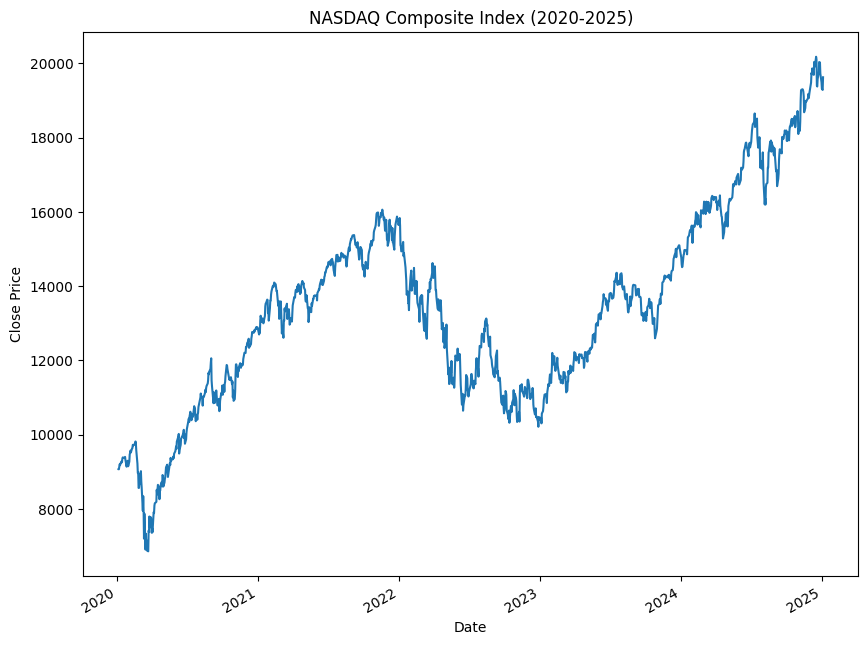

In [ ]:
plt.figure(figsize=(10, 8))
data.plot(title="NASDAQ Composite Index (2020-2025)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


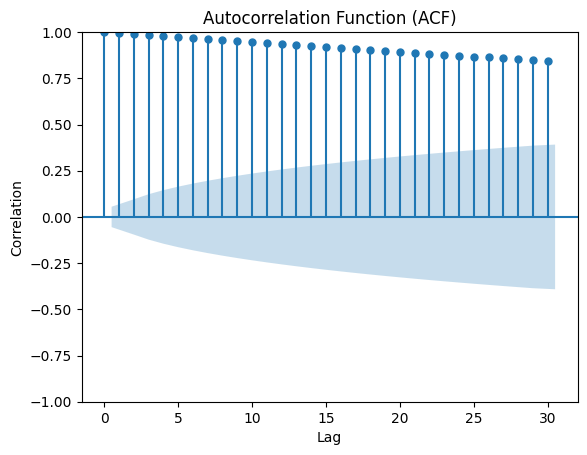

In [ ]:

plot_acf(data, lags=30)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

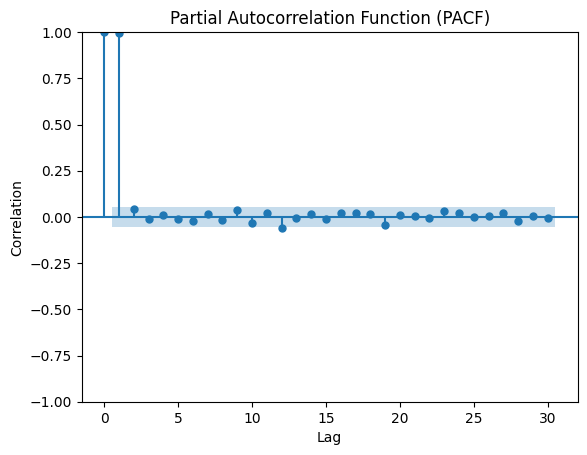

In [ ]:
plot_pacf(data, lags=30)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

## 2) decomposition de la serie chronologique

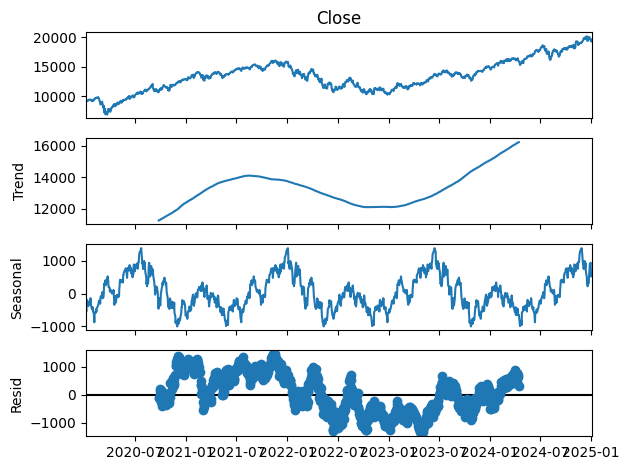

In [ ]:
decomposition = seasonal_decompose(data, model='additive', period=365)  # Période annuelle (365 jours)

# Afficher les composantes de la décomposition
decomposition.plot()
plt.show()


##3)verifier la non stationarite

In [ ]:
#test de Dickey-fuller
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
      print(f"{key}: {value}")
      if result[1] < 0.05:
        print("La série est stationnaire (Rejeter H0).")
      else:
        print("La série n'est pas stationnaire (Accepter H0).")

adf_test(data)

ADF Statistic: -0.508068
p-value: 0.890432
Critical Values:
1%: -3.4356048614183443
La série n'est pas stationnaire (Accepter H0).
5%: -2.8638605461891617
La série n'est pas stationnaire (Accepter H0).
10%: -2.5680054872544145
La série n'est pas stationnaire (Accepter H0).


## 4)trouver l'ordere de differenciation

Test ADF après différenciation d = 0:
ADF Statistic: -0.5080683637607687
p-value: 0.8904323691029028
La série n'est pas stationnaire même après la différenciation maximale.
Test ADF après différenciation d = 1:
ADF Statistic: -11.323642943246384
p-value: 1.1576966680587606e-20
Stationnarité atteinte après différenciation d = 1


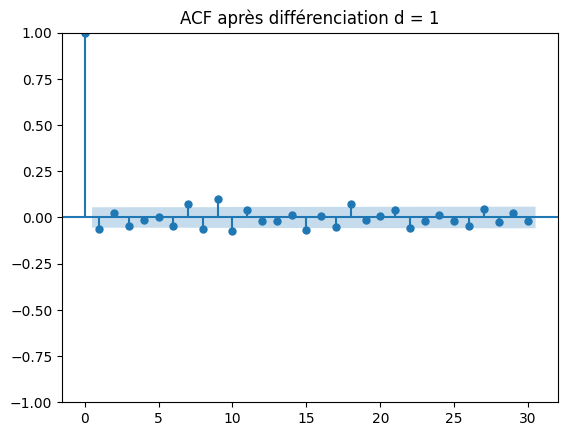

In [ ]:
def find_oredr_diff(series,max_diff=3):
  current_series=series
  d=0

  while(d<=max_diff):
    print(f"Test ADF après différenciation d = {d}:")
    adf_result = adfuller(current_series.dropna())  # Appliquer le test ADF
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])

    if adf_result[1] < 0.05:
      print(f"Stationnarité atteinte après différenciation d = {d}")
      plot_acf(current_series.dropna(), lags=30)  # Tracer l'ACF
      plt.title(f"ACF après différenciation d = {d}")
      plt.show()
      return d, current_series

    current_series=current_series.diff()
    d+=1

    print("La série n'est pas stationnaire même après la différenciation maximale.")


  return d, current_series

oredr_diff, data_diff = find_oredr_diff(data)

In [ ]:
data_diff = data_diff.dropna()

In [ ]:
data_diff = data_diff.reset_index(drop=True)

#5)trouvant l'ordre p pour AR

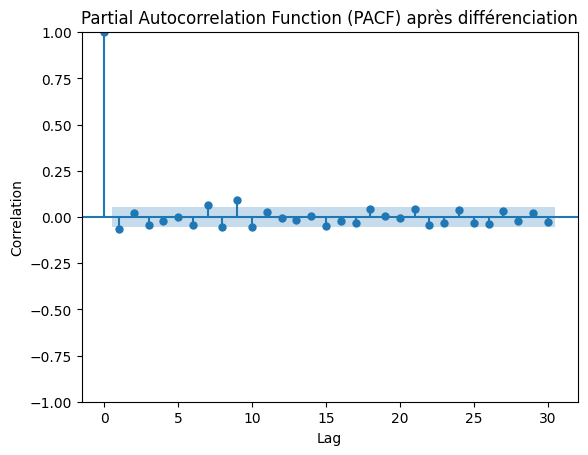

In [ ]:
plot_pacf(data_diff, lags=30)
plt.title("Partial Autocorrelation Function (PACF) après différenciation")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

il est claire que l'ordre ici de AR est de 10 car il montre que on a une forte correlation partielle avec le premier lag apres differenciation.

##6)Trouvant l'ordre pour MA

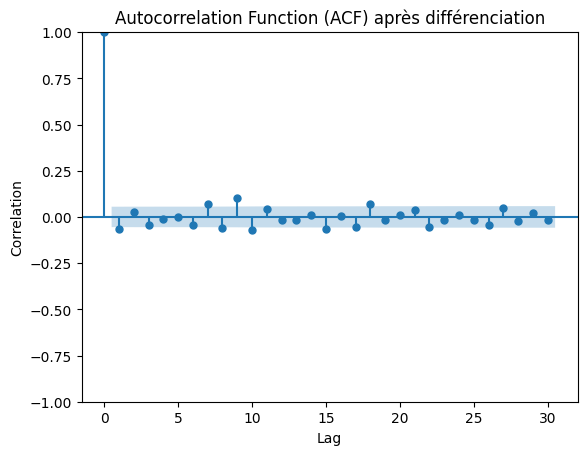

In [ ]:
plot_acf(data_diff, lags=30)
plt.title("Autocorrelation Function (ACF) après différenciation")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

DONC ici l'ordre q du MA est de 9

##7)comment on gere si la serie  chronologique est légèrement sous-différenciée ou sur-différenciée?

L'objectif principale de la differenciation est de rendre la serie stationnaire , cependant on a deux problèmes:

1) la sous differenciation:siginifie que la serie n'est pas stationnaire

2) la sur differenciation: la serie a été différencié trop de fois ce qui a resulter de bruits inutiles.

La solution du premier problème est d'appliquer encore les différenciations pour éliminer davantage la tendance ou la saisonnalité.

Et la solution pour le deuxième problème est: Réduire l'ordre de différenciation pour revenir à une version moins transformée de la série.

Text(0.5, 0, 'Date')

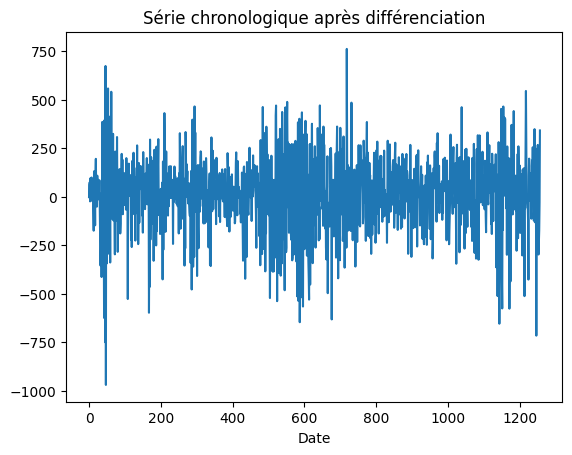

In [ ]:
data_diff.plot()
plt.title("Série chronologique après différenciation")
plt.xlabel("Date")

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("La série est stationnaire (p-value < 0.05).")
    else:
        print("La série n'est pas stationnaire (p-value >= 0.05).")

# Appliquer le test ADF sur la série différenciée
adf_test(data_diff)  # data_diff est votre série différenciée


ADF Statistic: -11.323642943246384
p-value: 1.1576966680587606e-20
La série est stationnaire (p-value < 0.05).


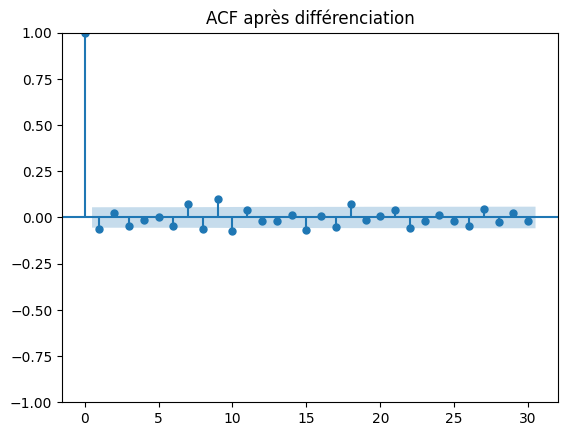

In [ ]:
plot_acf(data_diff, lags=30)
plt.title("ACF après différenciation")
plt.show()

D'après le graphique :
La série est correctement différenciée.

##8)  8. Choix d’un (de) modèle(s) ARIMA sur la série correctement stationnarisée à l’aide des autocorrélations,BIC,AIC

In [ ]:
model=ARIMA(data_diff,order=(10,1,9))
result=model.fit()

print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1257
Model:                ARIMA(10, 1, 9)   Log Likelihood               -8364.688
Date:                Sat, 25 Jan 2025   AIC                          16769.376
Time:                        17:16:10   BIC                          16872.090
Sample:                             0   HQIC                         16807.980
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5421      0.238     -2.275      0.023      -1.009      -0.075
ar.L2         -0.4123      0.283     -1.459      0.145      -0.966       0.142
ar.L3         -0.3099      0.334     -0.928      0.3

In [ ]:
# Tester quelques modèles proches pour confirmer le choix optimal
models_to_test = [(10,1,9),(10,1,18)]
results = []

for order in models_to_test:
    try:
        model = ARIMA(data_diff, order=order)
        result = model.fit()
        results.append((order, result.aic, result.bic))
    except:
        continue

# Afficher les résultats
import pandas as pd
results_df = pd.DataFrame(results, columns=["Order (p, d, q)", "AIC", "BIC"])
print(results_df.sort_values(by="AIC"))


  Order (p, d, q)           AIC           BIC
0      (10, 1, 9)  16769.376081  16872.089828
1     (10, 1, 18)  16775.493234  16924.428167


dans ce cas on priorise les criteres AIC et BIC vu qu'ils ont donne des resultats importants donc on peut ajouter une composante pour MA.

dans ce cas on va choisir arima(10,1,9)

##9)  Estimation du (des) modèle(s) ARIMA sélectionné(s)

In [ ]:
model_1 = ARIMA(data_diff, order=(10,1,9))
result_1 = model_1.fit()


# Afficher les résumés
print("Résumé ARIMA(10,1,9):")
print(result_1.summary())


Résumé ARIMA(10,1,9):
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1257
Model:                ARIMA(10, 1, 9)   Log Likelihood               -8364.688
Date:                Sat, 25 Jan 2025   AIC                          16769.376
Time:                        17:17:20   BIC                          16872.090
Sample:                             0   HQIC                         16807.980
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5421      0.238     -2.275      0.023      -1.009      -0.075
ar.L2         -0.4123      0.283     -1.459      0.145      -0.966       0.142
ar.L3         -0.3099      0.3

##10)tests de validation sur les residus

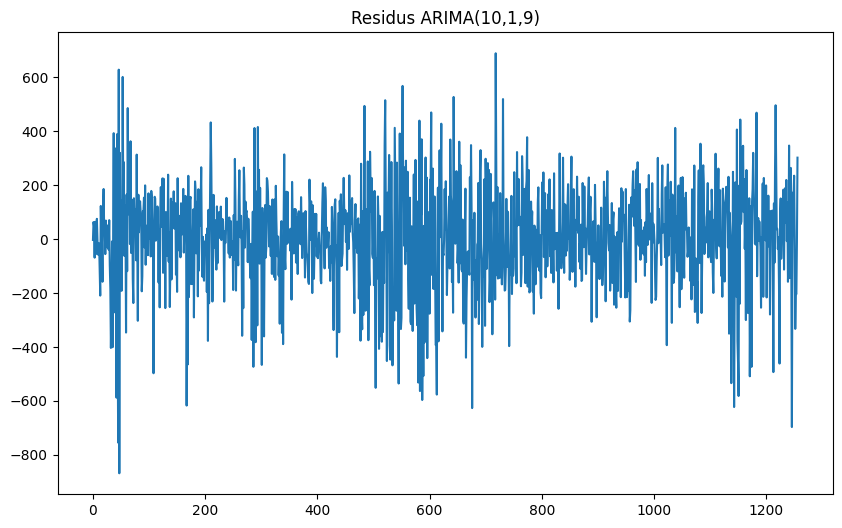

In [ ]:
residuals_110=result_1.resid
plt.figure(figsize=(10, 6))
residuals_110.plot()
plt.title("Residus ARIMA(10,1,9)")
plt.show()


In [ ]:
print(data_diff.isnull().sum())  # Nombre de valeurs manquantes


0


In [ ]:
model_11 = ARIMA(data_diff, order=(10,1,9))
model_fit = model_11.fit()
residuals_11 = model_fit.resid
print(residuals_11.head())


0    -2.889648
1    63.431369
2    48.298388
3   -68.639639
4    64.557621
dtype: float64


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test_11 = acorr_ljungbox(residuals_11, lags=[10], return_df=True)
print("Test de Ljung-Box pour ARIMA(10,1,9):",lb_test_11)


Test de Ljung-Box pour ARIMA(10,1,9):      lb_stat  lb_pvalue
10  1.846828   0.997385


Le test de Ljung-Box confirme que les résidus du modèle ARIMA(10,1,9) ne présentent pas d'autocorrélation significative.

Cela suggère que le modèle capture bien la structure des données et qu'il n'y a pas d'information résiduelle non exploitée.

In [ ]:
#test de heterogrnity

X_11 = np.column_stack((np.ones(len(residuals_11)), residuals_11**2))

bp_test_11 = het_breuschpagan(residuals_11, X_11)
print("Test de Breusch-Pagan pour ARIMA(10,1,9):")
print(f"Statistique: {bp_test_11[0]:.4f}")
print(f"p-value: {bp_test_11[1]:.4f}")



Test de Breusch-Pagan pour ARIMA(10,1,9):
Statistique: 1257.0000
p-value: 0.0000


Les résidus sont hétéroscédastiques.
La variance des résidus n'est pas constante.



In [ ]:
#normality test
jb_test_11= jarque_bera(residuals_11)
print("Test de Jarque-Bera pour ARIMA(10,1,9):")
print(f"Statistique: {jb_test_11[0]:.4f}")
print(f"p-value: {jb_test_11[1]:.4f}")

Test de Jarque-Bera pour ARIMA(10,1,9):
Statistique: 120.4835
p-value: 0.0000


Dans notre cas, la p-value est 0.0000, ce qui est bien inférieur à 0.05. Cela signifie que :

Les résidus ne suivent pas une distribution normale.

##10) Interpretation des tracés résiduels dans le modèle ARIMA (Standardized residuals, Distribution of residuals, Q-Q plot & ACF plot)

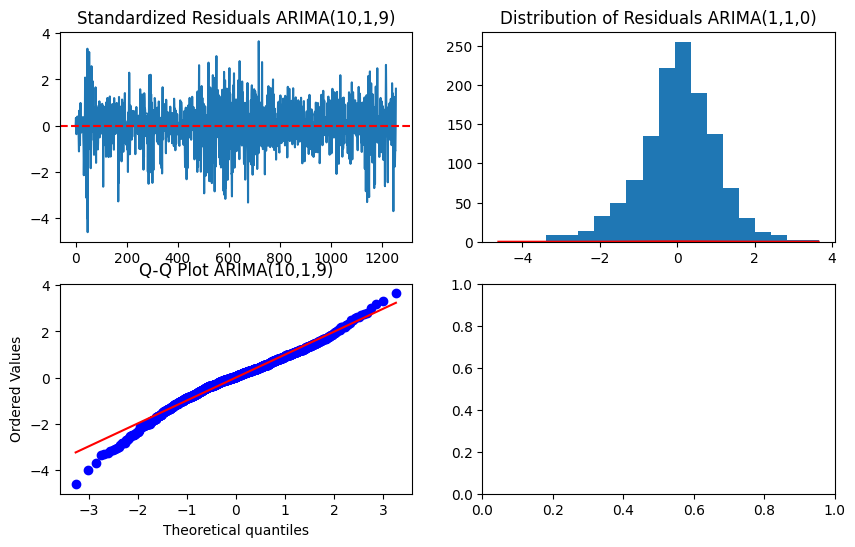

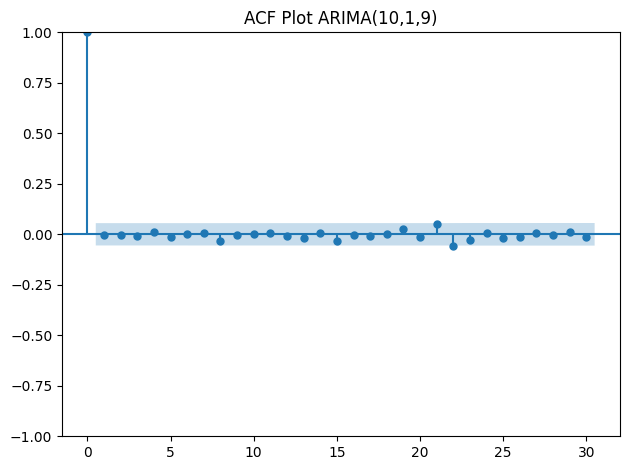

In [ ]:
standarized_resid_11=(residuals_11-np.mean(residuals_11))/np.std(residuals_11)

plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.plot(standarized_resid_11)
plt.title("Standardized Residuals ARIMA(10,1,9)")
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(222)
plt.hist(standarized_resid_11, bins=20)
x = np.linspace(min(standarized_resid_11), max(standarized_resid_11), 100)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r')
plt.title("Distribution of Residuals ARIMA(1,1,0)")

plt.subplot(223)
stats.probplot(standarized_resid_11, plot=plt)
plt.title("Q-Q Plot ARIMA(10,1,9)")

plt.subplot(224)
plot_acf(standarized_resid_11, lags=30)
plt.title("ACF Plot ARIMA(10,1,9)")

plt.tight_layout()
plt.show()


ce qu'on peut deduire comme interpretation d'apres ces graphes:
pour les residus standarized s'oscillent autour du 0.
pour la distribution des residus:on voit que la distribution est en forme de cloche a peu pres.

pour le Q-Qplot:Les points suivent un diagonale ce quis suggere que les residus se sont normalement distribues

La plupart des points d'autocorrélation (les cercles bleus) se situent à l'intérieur de la bande de confiance (les zones ombrées en bleu clair).
Cela indique qu'il n'y a pas d'autocorrélation significative dans les résidus, ce qui est un bon signe : le modèle ARIMA capture correctement les relations temporelles.

##12)Sélection du modèle pertinent s’il reste plusieurs modèles possibles à l’aide de prévisions (en échantillon)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

fittedvalues_11 = result_1.fittedvalues[1:]  # Ignorer la première valeur NaN due à la différenciation

# Vérifier que les séries ont la même longueur
print("Longueur de data_diff:", len(data_diff))
print("Longueur de fittedvalues_110:", len(fittedvalues_11))


Longueur de data_diff: 1257
Longueur de fittedvalues_110: 1256


In [ ]:
data_diff_aligned = data_diff.iloc[1:]  # Utilisez iloc pour les séries pandas


In [ ]:
print("Longueur de data_diff:", len(data_diff_aligned))
print("Longueur de fittedvalues_110:", len(fittedvalues_11))

Longueur de data_diff: 1256
Longueur de fittedvalues_110: 1256


In [ ]:
mse_11 = mean_squared_error(data_diff_aligned, fittedvalues_11)
rmse_11 = np.sqrt(mse_11)
mae_11 = mean_absolute_error(data_diff_aligned, fittedvalues_11)


# Afficher les résultats
print("Métriques pour ARIMA(10,1,9):")
print("MSE:", mse_11)
print("RMSE:", rmse_11)
print("MAE:", mae_11)


Métriques pour ARIMA(10,1,9):
MSE: 35551.92097481773
RMSE: 188.55217043252972
MAE: 141.75522163494674


##13. Trouver le modèle ARIMA optimal à l’aide de validation croisée imbriquée de séries chronologiques (Out of-Time Cross validation);

In [ ]:

from sklearn.model_selection import TimeSeriesSplit


def time_series_cv(data, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results_11 = []

    for train_idx, test_idx in tscv.split(data):
        train = data[train_idx]
        test = data[test_idx]

        # Ajuster les modèles
        model_11 = ARIMA(train, order=(10,1,9))
        fitted_11 = model_11.fit()

        # Faire des prédictions
        pred_11 = fitted_11.forecast(steps=len(test))

        # Calculer RMSE
        rmse_11 = np.sqrt(mean_squared_error(test, pred_11))
        results_11.append(rmse_11)

    return results_11  # Retourne la liste des RMSE pour chaque pli
  # Remplacez par vos données
rmse_scores = time_series_cv(data_diff, n_splits=5)
print("RMSE pour chaque pli :", rmse_scores)
print("RMSE moyen :", np.mean(rmse_scores))

RMSE pour chaque pli : [151.63420700539206, 243.87676188149732, 187.36311415778965, 139.85152420537733, 204.0371278373554]
RMSE moyen : 185.35254701748235


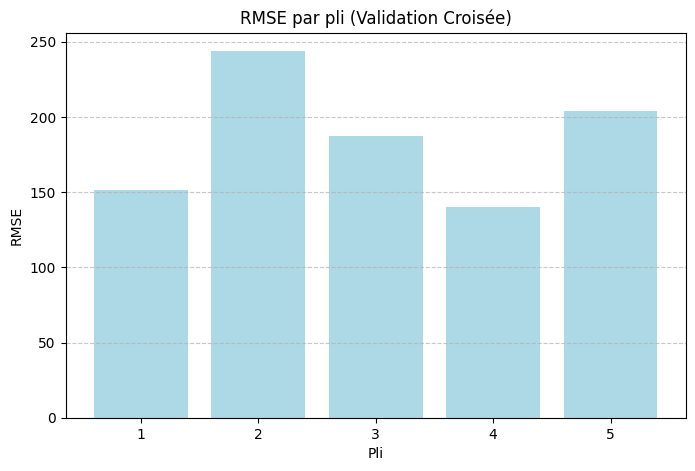

In [ ]:

# Données RMSE par pli
rmse_scores = [151.63420700539206, 243.87676188149732, 187.36311415778965, 139.85152420537733, 204.0371278373554]

# Barplot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(rmse_scores) + 1), rmse_scores, color='lightblue')
plt.title("RMSE par pli (Validation Croisée)")
plt.ylabel("RMSE")
plt.xlabel("Pli")
plt.xticks(range(1, len(rmse_scores) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

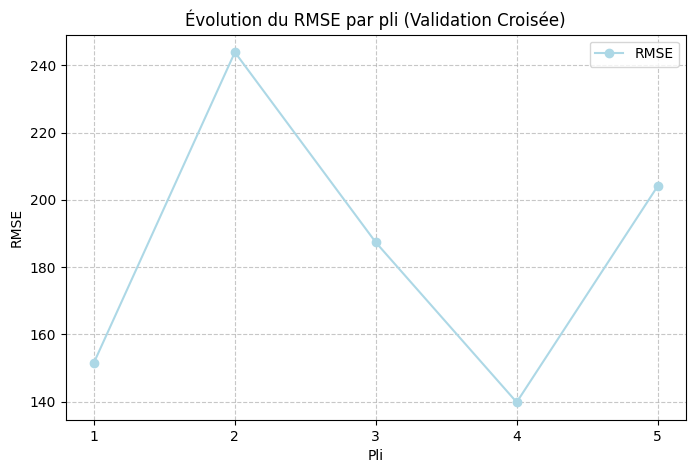

In [ ]:
import matplotlib.pyplot as plt

# Données RMSE par pli
rmse_scores =  [151.63420700539206, 243.87676188149732, 187.36311415778965, 139.85152420537733, 204.0371278373554]

# Graphique en ligne
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o', linestyle='-', color='lightblue', label='RMSE')
plt.title("Évolution du RMSE par pli (Validation Croisée)")
plt.ylabel("RMSE")
plt.xlabel("Pli")
plt.xticks(range(1, len(rmse_scores) + 1))
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()

##14. Mesures de précision pour les prévisions de la série chronologique;

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import numpy as np

# Séparation des données
train_size = int(len(data_diff) * 0.8)  # 80 % pour l'entraînement
train_data = data_diff[:train_size]  # Ensemble d'entraînement (différences)
test_data = data_diff[train_size:]   # Ensemble de test (différences)

# Entraînement du modèle ARIMA
model = ARIMA(train_data, order=(10,1,9))
model_fit = model.fit()

# Prévisions sur les différences
forecast_diff = model_fit.forecast(steps=len(test_data))

# Réintégration des différences pour obtenir les prévisions originales
forecast_original = forecast_diff.cumsum() + data.iloc[train_size- 1]  # Utiliser la dernière valeur de l'entraînement

# Comparaison avec les valeurs réelles (série originale)
true_values = data[train_size:]  # Valeurs réelles de la série originale

min_len = min(len(true_values), len(forecast_original))
true_values = true_values[:min_len]
forecast_original = forecast_original[:min_len]



mse = mean_squared_error(true_values, forecast_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, forecast_original)
r2 = r2_score(true_values, forecast_original)
mape = mean_absolute_percentage_error(true_values, forecast_original)

# Affichage des métriques
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"MAPE: {mape}")

MSE: 4115976.756315082
RMSE: 2028.7870160061361
MAE: 1771.5988930695164
R2: -1.2155083800880964
MAPE: 0.09880131765145155


## 15. Calcul de prévisions hors échantillon du 05/01/2025 au 05/02/2025;


In [ ]:
print(data_diff.isnull().sum())


0


In [ ]:
model_111 = ARIMA(data_diff, order=(10, 1, 9))
result_111 = model_111.fit()
forecast = result_111.predict(n_periods=30)
print("Prévisions pour janvier 2025:", forecast)

Prévisions pour janvier 2025: 0        0.000000
1       -2.771213
2       25.891066
3       44.070304
4       30.511715
          ...    
1252    34.537622
1253   -34.401836
1254    27.755080
1255   -24.949912
1256    38.448243
Name: predicted_mean, Length: 1257, dtype: float64


 ## 16) Comment faire Auto Arima Forecast en Python.


In [ ]:
auto_model = auto_arima(data_diff, seasonal=True, m=12, trace=True, stepwise=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=8.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16784.564, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16783.228, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16783.451, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=16784.971, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=16781.527, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=16783.233, Time=1.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=16785.220, Time=5.84 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=16782.884, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=16782.339, Time=0.92 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=16781.752, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=16784.425, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=16782.244, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 18.067 seconds


## Faisons les previsions avec deep learning

In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Construction du modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Entraînement
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Prédictions
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.2116 - val_loss: 0.0233
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012 - val_loss: 0.0072
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0012 - val_loss: 0.0098
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0010 - val_loss: 0.0063
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 9.6663e-04 - val_loss: 0.0062
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 9.1034e-04 - val_loss: 0.0040
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 8.1885e-04 - val_loss: 0.0029
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 7.6185e-04 - val_loss: 0.0018
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7.4884e-04 - val_loss: 0.0012
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 4

In [ ]:
# Calcul des métriques
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE LSTM: {rmse_lstm}")

RMSE LSTM: 348.45274154376074


In [ ]:
# Comparaison avec ARIMA
order = auto_model.order
model = ARIMA(data_diff, order=order)
model_fitted = model.fit()
forecast_arima = model_fitted.forecast(steps=len(y_test))
rmse_arima = np.sqrt(mean_squared_error(y_test_rescaled, forecast_arima))
print(f"RMSE ARIMA: {rmse_arima}")

RMSE ARIMA: 17388.20273666318


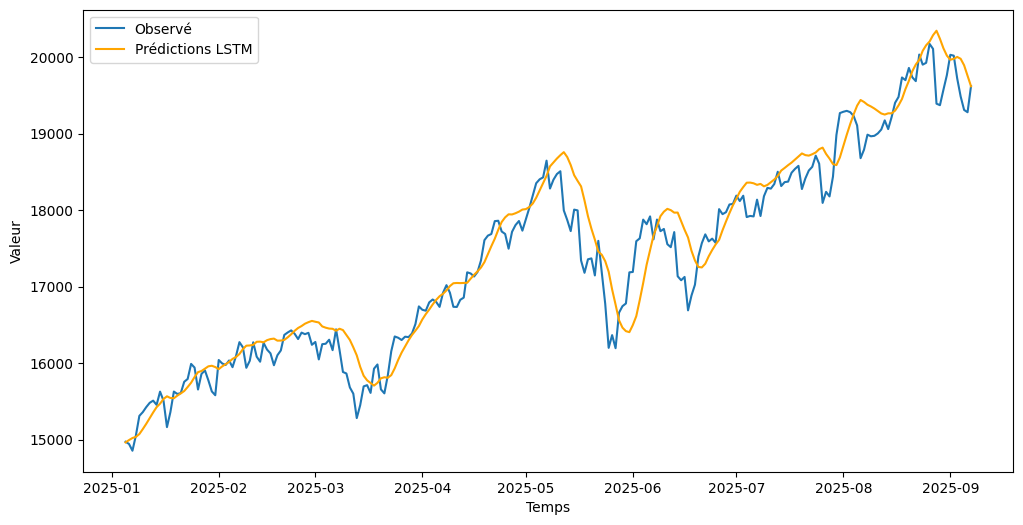

In [ ]:
plt.figure(figsize=(12, 6))
dates = pd.date_range(start='2025-01-05', periods=len(y_test_rescaled), freq='D')

plt.plot(dates, y_test_rescaled, label='Observé')
plt.plot(dates, y_pred_rescaled, label='Prédictions LSTM', color='orange')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()
